# Motivation and summary
We are currently relying on ARIA vessel segmentation for quality control of our images. Mattia used two parameters, 1) the number of vessel segments and 2) the total length of all segments, on which he put both lower and upper thresholds.

While these parameters allowed us to reach a heritability of ~0.25 on distance factor tortuosity, and a sample size of around 62000, these thresholds are arbitrary, and may not be overall good quality control of the images.

Therefore, here I present various standard image quality control parameters, as well the output of the neural net L-WNET as alternatives to the old QC, relying on resulting h_SNP on DF tortuosity for making a decision

In [1]:
import sys,os, glob
import numpy as np
import pandas as pd

from shutil import copyfile

import cv2
from matplotlib import pyplot as plt

In [150]:
# CONFIGS for UKBB

LWNETDIR="/HDD/data/UKBB/fundus/lwnet/"

MASK_RADIUS=660 # works for UKBB images
RESIZE_RADIUS=500 # normalization factor to standardize images at size
BLOT_THRESHOLD=0.12 # what luminosity will be a blot
LIGHT_BLOT_THRESHOLD=0.95
DILATION_SIZE = 1 # in case one wants to dilate the raw blot -> set larger than 1

h,w=(1536, 2048)

correction_factor = h*w / (MASK_RADIUS**2 * np.pi) / 255 * 3 * 100
# A correction factor because LWNET vessel fraction was computed on full canvas, and in MATLAB
# h*w                      : canvas size
# (MASK_RADIUS**2 * np.pi) : mask area
# /255                     : in MATLAB, intensity goes from 0 to 255, but we want 0-1
# *3                       : lwnet is either R or B, meaning max 1/3 grayscale pixel intensity. we correct for that
# *100                     : percent

# Parameters and their thresholds
We have the following parameters now:

| Parameter | Description |
| --- | --- |
| Mean | The mean grayscale luminosity |
| SDEV | The standard deviatio of grayscale luminosity |
| Blotsize | Many images have dark spots due to poor illumination. Using cv2's standard processing function "dilate", computed the area of the largest dark spot in an image, where a dark spot is defined as a dilated area with luminosity below a certain threshold. See `newQC_multiprocess.py` for details.
| Lightblotisze | Same, but with too high luminosity as threshold.
| Vasculature | PBV (percent annotated as blood vessels), a value derived from LWNET output.

After some playing around, I settled with max_mean, max_sdev, max_blotsize, min_vasculature, max_lightblotsize.

In [151]:
MAX_MEAN = 1e9 #165
MAX_SDEV = 1e9 #0.4
MAX_BLOTSIZE = 1e9 #30000
MIN_VASCULATURE = 4 #0.1*correction_factor
MAX_LIGHTBLOTSIZE= 1e9 #33

In [152]:
# FUNCTIONS

def keep_throw(df,col,threshold, lower=True):

  if lower == True:
    return (df[df[col] <= threshold], df[df[col] > threshold])
  else:
    return (df[df[col] >= threshold], df[df[col] < threshold])

def n_participants(files):
  return len(set([i.split("_")[0] for i in files]))

def fileinfo(file):
  img=plt.imread(rawdir+file)
  plt.imshow(img)
  print(stats.loc[file])

def cp_content(src,dst,files,lwnet=True):

  rmfiles = glob.glob(dst+'*')
  for f in rmfiles:
    os.remove(f)

  for i in files:
    copyfile(src+i, dst+i)
    if lwnet==True:
      try:
        copyfile(LWNETDIR+i, dst+i.split(".png")[0]+"_seg.png")
      except:
        pass


def compare_image(image1, image2):
  plt.figure(figsize=(9,9))
  plt.subplot(1,2,1)
  plt.imshow(image1)
  plt.title('Orignal')
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(image2)
  plt.title('Modified')
  plt.axis('off')

  plt.tight_layout()

def mask_image(img, toGray=False):
  hh,ww=img.shape[:2]
  #print(hh//2,ww//2)

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  mask = np.zeros_like(gray)
  mask = cv2.circle(mask, (ww//2,hh//2), RESIZE_RADIUS, (255,255,255), -1)
  #mask = np.invert(mask.astype(bool))

  #result = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
  #result[:, :] = mask[:,:]
#  result[:, :, 3] = mask[:,:,0]
  #plt.imshow(result)
  
  if toGray == True:
    return np.ma.array(gray, mask=np.invert(mask.astype(bool)))
  else:
    return np.ma.array(img, mask=np.invert(mask.astype(bool)))

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    plt.imshow(labeled_img)

def blot_size(img, lightBlot=False):

  if lightBlot==True:
    thresh=LIGHT_BLOT_THRESHOLD
  else:
    thresh=BLOT_THRESHOLD

  gray = mask_image(img, toGray=True)
  #gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
  nGray = gray.copy()
  #quantile = np.quantile(gray[gray.mask==False], BLOT_QUANTILE)
  #print(quantile)

  #nGray[nGray == 0] = 1
  #plt.hist(nGray)
  nGray[nGray.mask == True] = 1

  if lightBlot==False:
    nGray[(nGray<thresh) & (nGray.mask == False)] = 0
  else:
    nGray[(nGray>thresh) & (gray.mask == False)] = 0
    plt.imshow(nGray)

  kernel = np.ones((DILATION_SIZE, DILATION_SIZE), 'uint8')
  dilate_img = cv2.erode(nGray, kernel, iterations=1)
  view = dilate_img.copy()
  view[view==0] = 0.8


  #nGray[nGray==0] = 1
  #compare_image(img,view)

  #binary = cv2.threshold(dilate_img, 0, 255, cv2.THRESH_BINARY)[1]
  binary = (dilate_img > 0).astype(np.uint8)
  binary = 1-binary
  connectivity = 4
  num_labels,labels,surfaceStats,centroids = cv2.connectedComponentsWithStats(binary, connectivity, cv2.CV_32S)
  imshow_components(labels)
  try:
    if lightBlot==False:
      return np.max(surfaceStats[1:,4])
    else:
      print(surfaceStats, '\n\n')
      return np.max(surfaceStats[2:,4])
  except:
    return 0

In [153]:
# DATA

rawdir="/HDD/data/UKBB/fundus/raw/CLRIS/"
rawfiles = os.listdir(rawdir)

lwnetMean = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/lwnetmean.csv", header=None)
lwnetMean.columns = ['file', 'mean']
lwnetMean = lwnetMean.set_index('file')

# Raw distribution of QC parameters

(173814, 5)


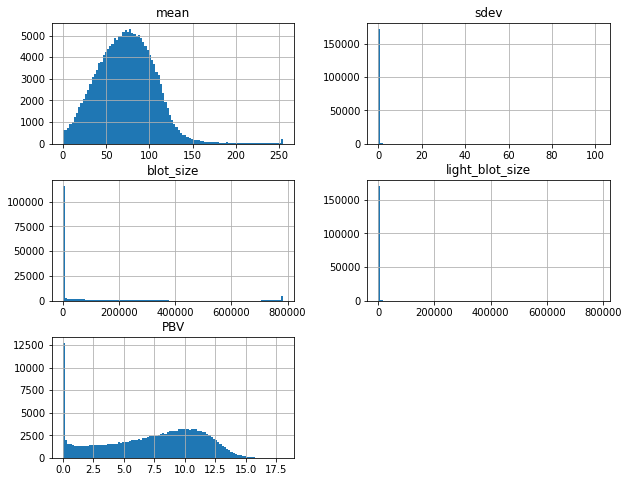

In [154]:
#stats = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/newQC_rawStats.csv")
stats = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/newQC_rawStats.csv", index_col=0)
stats = stats.set_index("file")
stats['PBV'] = lwnetMean['mean'].loc[stats.index] * correction_factor

#stats = stats[0:3000]
print(stats.shape)
f=stats.hist(bins=100, figsize=(10,8))


# How many images are filtered by which threshold?

In [155]:
print("RAW IMAGES", stats.shape[0])

throw_bright = stats[stats['mean'] > MAX_MEAN]
keep_bright = stats[stats['mean'] <= MAX_MEAN]
print('too bright',throw_bright.shape[0])
keep_sdev, throw_sdev = keep_throw(keep_bright, 'sdev', MAX_SDEV)
print('too high SD',throw_sdev.shape[0])
keep_blots, throw_blots = keep_throw(keep_sdev, 'blot_size', MAX_BLOTSIZE)
print('too much blot',throw_blots.shape[0])

keep_vasculature, throw_vasculature = keep_throw(keep_blots, 'PBV', MIN_VASCULATURE, lower=False)
print('too few lwnet vasculature',throw_vasculature.shape[0])

keep, throw_lightblots = keep_throw(keep_vasculature, 'light_blot_size', MAX_LIGHTBLOTSIZE, lower=True)
print('too much light blot',throw_lightblots.shape[0])

#remove double images for same visit
# double_imgs=[]
# for i in keep.index:
#     if i.split("_")[3] == "1.png":
#         first_img = i.split("_1.png")[0]+"_0.png"
#         if first_img in keep.index:
#             double_imgs.append(first_img)

# keep=keep.drop(double_imgs)


# print("# double images removed",len(double_imgs))

keep_parts=set([i.split("_")[0] for i in keep.index])
keep_files = set(keep.index)

print("REMAINING images", keep.shape[0])

RAW IMAGES 173814
too bright 0
too high SD 0
too much blot 0
too few lwnet vasculature 42769
too much light blot 0
REMAINING images 129193


# Distribution of QC parameters after filtering

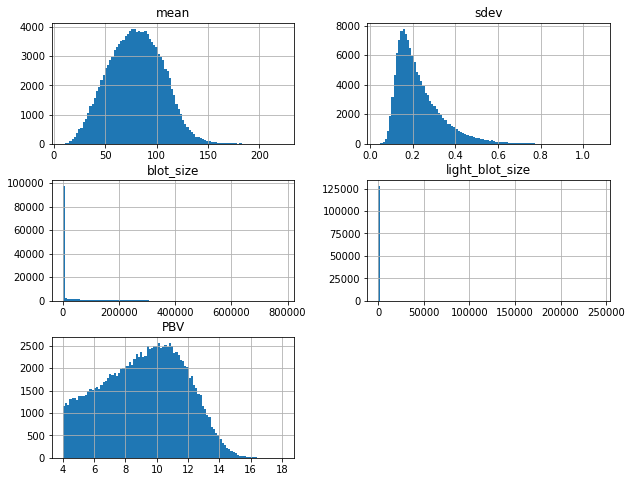

In [156]:
keep.hist(bins=100, figsize=(10,8));

# Mattia's QC vs new QC
Comparing Mattia's QC with the new QC when using the current thresholds.

In [163]:
mattiaQC = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/mattiaQC_participants.txt", header=None, names=['participants'], dtype=str)
mattiaQC_parts = set(mattiaQC['participants'])

mattiaQC = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/mattiaQC_images.txt", header=None, names=['files'], dtype=str)
mattiaQC_files = set(mattiaQC['files'])
mattiaQC_files = set([i for i in list(mattiaQC_files) if i in stats.index]) # getting rid of withdrawn participants


only_mattiaQC = mattiaQC_files-keep_files
only_newQC = keep_files-mattiaQC_files
print(len(only_mattiaQC), len(only_newQC))


# cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/pass_mattiaQC/", list(mattiaQC_files)[0:2000])
# cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/onlyMattiaQC/", list(only_mattiaQC)[0:2000])
# cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/onlyNewQC/", list(only_newQC)[0:2000])

print('mattiaQC:', len(mattiaQC_parts))
print('newQC:', len(keep_parts))
print('intersect:', len(mattiaQC_parts&keep_parts))

3701 16622
mattiaQC: 65033
newQC: 70407
intersect: 63839


# The different candidates for new QC
Playing around with the various "knobs" and looking at the raw images that are filtered out and kept, I wasn't able to find a clear better QC. Either the resulting sample size was too small, or I was seeing images of poor quality pass the QC.

Therefore, Sven suggested generating a few QC candidates, and running GWAS with median DF tortuosity for the various candidates, using h_SNP as a judge.

## Max. overlap between LWNET QC and ARIA QC

One candidate threshold for LWNET-based QC is the location of maximal overlap in terms of kept participants:

In [164]:
thresholds = np.quantile(stats['PBV'].loc[stats['PBV'] > 0], np.linspace(1,999, 999)/1000)

intersect=[]
union=[]
overlap=[]
N_i = []
for i,thres in enumerate(thresholds):

    pass_files = set(stats[stats['PBV'] > thres].index)
    N_i.append(len(set([j.split('_')[0] for j in pass_files])))
    intersect.append(pass_files & mattiaQC_files)
    union.append(pass_files | mattiaQC_files)

    overlap.append( len(intersect[i]) / len(union[i]) )

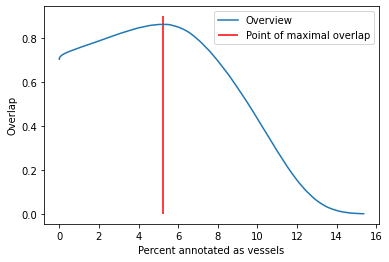

In [165]:
imax = np.argmax(overlap)
deciles = np.quantile(stats['PBV'].loc[stats['PBV'] > 0], np.linspace(1,9, 9)/10)

plt.plot(thresholds,overlap)
plt.vlines(thresholds[imax], 0, 0.9, color='r')
# for i in deciles:
#     plt.vlines(i, 0, 0.9, color='g')
plt.xlabel("Percent annotated as vessels")
plt.ylabel("Overlap")
plt.legend(["Overview", "Point of maximal overlap"])

## Deciles

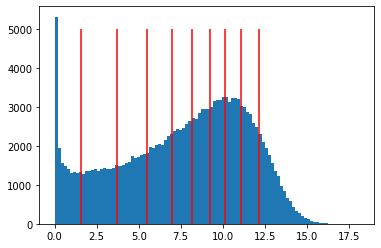

In [166]:
plt.hist(stats['PBV'].loc[stats['PBV'] > 0], 100)
for i in deciles:
    plt.vlines(i,0,5000, color='red')

# Results
The following is the list of candidates chosen

|Name|Description|
|---|---|
|No QC|Keeping all the images
|Knobs|Three different combinations of standard parameter thresholds, resulting in various Ns (exact parameters in my notebook)
|LWNET|Using only PBV as estimated by LWNET for QC

In [160]:
qc_results = pd.DataFrame({\
    'N' : [72599,70161,62703,55522,74938,68831,62012,54635,46776,38486,29824,20677,10930,80095,67899,63242,81522],
    'h_SNP Affymetrix' : [np.nan,np.nan,0.3144,0.2748,0.3078,0.3212,0.325,0.2994,0.2726,0.2336,0.2052,0.1318,0.0665,0.2701,0.3216,0.3255,0.2645],\
    'h_SNP Full' : [0.2253,0.2308,0.2446,0.2095,0.2394,0.2558,0.2543,0.2342,0.2029,0.1674,0.1421,0.105,0.0581,0.2174,0.2576,0.2556,0.2123]},\
    index=['Knobs 2','Knobs 3', 'Mattia\'s QC', 'Knobs 1', 'LWNET Decile 1', "LWNET Decile 2", "LWNET Decile 3", "LWNET Decile 4", "LWNET Decile 5","LWNET Decile 6","LWNET Decile 7","LWNET Decile 8","LWNET Decile 9", "LWNET > 0", "LWNET mode", "LWNET max Overlap", "no QC"])

In [161]:
qc_results=qc_results.sort_values("h_SNP Affymetrix", ascending=False)
qc_results['Affymetrix rank'] = list(range(1,len(qc_results)+1))
qc_results=qc_results.sort_values("h_SNP Full", ascending=False)
qc_results['Full rank'] = list(range(1,len(qc_results)+1))

qc_results.sort_values("h_SNP Full", ascending=False)

,N,h_SNP Affymetrix,h_SNP Full,Affymetrix rank,Full rank
LWNET mode,67899,0.3216,0.2576,3,1
LWNET Decile 2,68831,0.3212,0.2558,4,2
LWNET max Overlap,63242,0.3255,0.2556,1,3
LWNET Decile 3,62012,0.3250,0.2543,2,4
Mattia's QC,62703,0.3144,0.2446,5,5
LWNET Decile 1,74938,0.3078,0.2394,6,6
LWNET Decile 4,54635,0.2994,0.2342,7,7
Knobs 3,70161,NaN,0.2308,17,8
Knobs 2,72599,NaN,0.2253,16,9
LWNET > 0,80095,0.2701,0.2174,10,10


-> The first take-home message here is that Affymetrix GWAS output results in overestimated h_SNP.

For QC, we reach maximal h_SNP in a LWNET-based QC, increasing both N and h_SNP compared to the ARIA QC.

To further see where we should set the threshold, I plotted N against h_SNP.

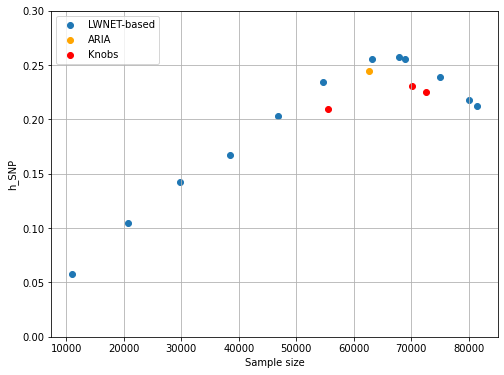

In [186]:
qc_results=qc_results.sort_values("N", ascending=False)
idx_lwnet = [0,1,2,5,6,7,11,12,13,14,15,16]
mattia = 8
knobs = [3,4,10]
plt.figure(figsize=(8,6))
plt.scatter(qc_results['N'].iloc[idx_lwnet],qc_results['h_SNP Full'].iloc[idx_lwnet])
plt.scatter(qc_results['N'].iloc[mattia],qc_results['h_SNP Full'].iloc[mattia], c='orange')
plt.scatter(qc_results['N'].iloc[knobs],qc_results['h_SNP Full'].iloc[knobs], c='red')
plt.ylim([0,0.3])
plt.legend(['LWNET-based', "ARIA", "Knobs"])
plt.xlabel("Sample size")
plt.ylabel("h_SNP")
plt.grid()

LWNET QC outperforms all other QCs.

With the new QC, we can have N of around 68000 - 6000 higher than before - also gaining 0.5 in h_SNP.

-> All in all, I suggest using a new QC based only on LWNET PBV, setting the threshold at ca. 5.25%

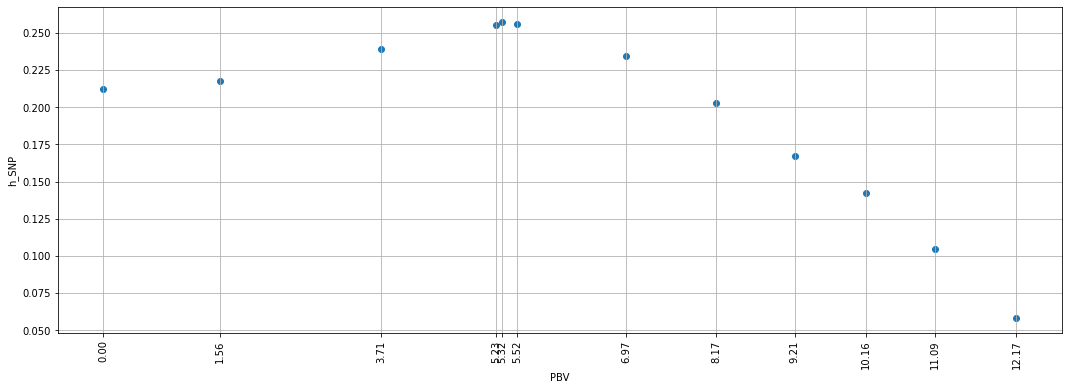

In [198]:
plt.figure(figsize=(18,6))
pbvs = [ *[0], *deciles[0:3], *[5.32,thresholds[imax]], *deciles[3:9] ]
len(pbvs)
plt.scatter(pbvs,qc_results['h_SNP Full'].iloc[idx_lwnet])
plt.xticks(pbvs, rotation='vertical')
plt.xlabel("PBV")
plt.ylabel("h_SNP")
plt.grid()

# Remaining open question

We are still relying on vasculature for QC, so if somebody can come up with standard-parameter QC that works better, feel free to continue playing around!

# END OF REPORT
# BEGINNING OF EXPLORATION

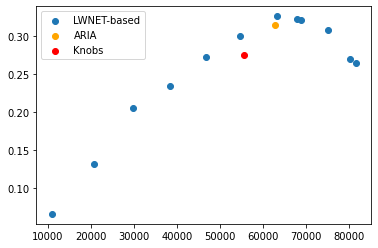

In [93]:
qc_results=qc_results.sort_values("N", ascending=False)
idx_lwnet = [0,1,2,5,6,7,11,12,13,14,15,16]
mattia = 8
knobs = [3,4,10]
plt.scatter(qc_results['N'].iloc[idx_lwnet],qc_results['h_SNP Affymetrix'].iloc[idx_lwnet])
plt.scatter(qc_results['N'].iloc[mattia],qc_results['h_SNP Affymetrix'].iloc[mattia], c='orange')
plt.scatter(qc_results['N'].iloc[knobs],qc_results['h_SNP Affymetrix'].iloc[knobs], c='red')
plt.legend(['LWNET-based', "ARIA", "Knobs"])

(145608, 5)


array([[<AxesSubplot:title={'center':'mean'}>,
        <AxesSubplot:title={'center':'sdev'}>],
       [<AxesSubplot:title={'center':'blot_size'}>,
        <AxesSubplot:title={'center':'light_blot_size'}>],
       [<AxesSubplot:title={'center':'lwnetmean'}>, <AxesSubplot:>]],
      dtype=object)

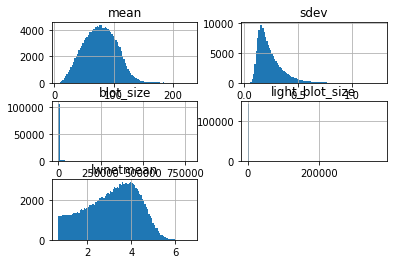

In [10]:
explore = keep
explore=explore.sort_values("light_blot_size",ascending=False)
print(explore.shape)
explore.hist(bins=100)

In [11]:
i = 0
#i = "1035157_21015_0_0.png"
print(i)
#print(explore.loc[i])
print(explore.iloc[i])
#img = plt.imread(rawdir+i)
img=plt.imread(rawdir+explore.index[i])
width = img.shape[1]
height = img.shape[0]
new_size=(int(width*RESIZE_RADIUS/MASK_RADIUS), int(height*RESIZE_RADIUS/MASK_RADIUS))
img = cv2.resize(img, new_size)

gray = mask_image(img, toGray=True)
#gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
nGray = gray.copy()

#quantile = np.quantile(gray[gray.mask==False], BLOT_QUANTILE)
#print(quantile)

#nGray[nGray == 0] = 1
#plt.hist(nGray)
nGray[nGray.mask == True] = 1

nGray[(nGray>0.99) & (nGray.mask == False)] = 0

kernel = np.ones((3, 3), 'uint8')
dilate_img = cv2.erode(nGray, kernel, iterations=1)
view = dilate_img.copy()
view[view==0] = 0.3


#nGray[nGray==0] = 1
compare_image(img,view)

# #binary = cv2.threshold(dilate_img, 0, 255, cv2.THRESH_BINARY)[1]
# binary = (dilate_img > 0).astype(np.uint8)
# binary = 1-binary
# connectivity = 4
# num_labels,labels,surfaceStats,centroids = cv2.connectedComponentsWithStats(binary, connectivity, cv2.CV_32S)

# print(np.max(surfaceStats[1:,4]))

0
mean                  229.770216
sdev                    0.140479
blot_size               0.000000
light_blot_size    369194.000000
lwnetmean               1.143627
Name: 5867384_21015_0_0.png, dtype: float64


FileNotFoundError: [Errno 2] No such file or directory: '/HDD/data/UKBB/fundus/raw/5867384_21015_0_0.png'

In [48]:
#binary = cv2.threshold(dilate_img, 0, 255, cv2.THRESH_BINARY)[1]
binary = (dilate_img > 0).astype(np.uint8)
binary = 1-binary
connectivity = 4
num_labels,labels,surfaceStats,centroids = cv2.connectedComponentsWithStats(binary, connectivity, cv2.CV_32S)

NameError: name 'dilate_img' is not defined

In [49]:
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_1bright/", throw_bright.index)
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_2highSD/", throw_sdev.index)
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_3blot/", throw_blots.index)
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_4lwnet/", throw_vasculature.index)
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_5lightblot/", throw_lightblots.index)
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/pass/", keep.index)

FileNotFoundError: [Errno 2] No such file or directory: '/HDD/data/UKBB/fundus/raw/1019619_21015_1_0.png'

In [27]:
with open("/HDD/data/UKBB/fundus/qcStats/knobs3.txt", 'w') as f:
    for i in keep.index:
        f.write(i+"\n")

In [617]:
df_onlyMattia = stats.loc[only_mattiaQC]
df_onlyNew = stats.loc[only_newQC]
df_mattiaQD = stats.loc[mattiaQC_files]

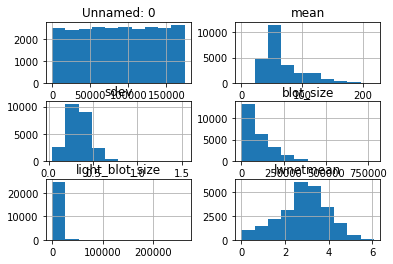

In [582]:
df_onlyMattia.hist();

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'mean'}>],
       [<AxesSubplot:title={'center':'sdev'}>,
        <AxesSubplot:title={'center':'blot_size'}>],
       [<AxesSubplot:title={'center':'light_blot_size'}>,
        <AxesSubplot:title={'center':'lwnetmean'}>]], dtype=object)

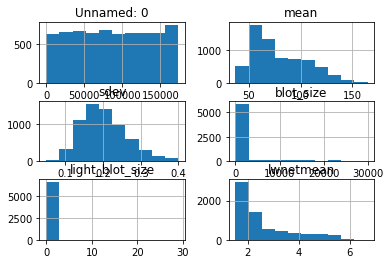

In [583]:
df_onlyNew.hist()

In [ ]:
kernel = np.ones((50,50),np.uint8)
dilation = cv2.dilate(img,kernel,iterations=1)
compare_image(img,dilation)


Error: Kernel is dead

In [ ]:
stats = pd.DataFrame({'file':rawfiles, 'mean':np.nan,'stdev':np.nan,'blot_size':np.nan})

for i,myf in enumerate(rawfiles[0:]):
    img = plt.imread(rawdir+myf)
    width = img.shape[1]
    height = img.shape[0]
    new_size=(int(width*RESIZE_RADIUS/MASK_RADIUS), int(height*RESIZE_RADIUS/MASK_RADIUS))
    print(img.shape)
    img = cv2.resize(img, new_size)
    plt.imshow(img)
    print(img.shape)
    
    hh,ww=img.shape[:2]
    #print(hh//2,ww//2)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    mask = np.zeros_like(gray)
    mask = cv2.circle(mask, (ww//2,hh//2), RESIZE_RADIUS, (255,255,255), -1)
    #mask = np.invert(mask.astype(bool))

    #result = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    #result[:, :] = mask[:,:]
#    result[:, :, 3] = mask[:,:,0]
    #plt.imshow(result)
    mskd_img=np.ma.array(gray, mask=np.invert(mask.astype(bool)))

    stats['mean'].iloc[i]=mskd_img.mean()*255
    stats['stdev'].iloc[i]=mskd_img.std()*255 / stats['mean'].iloc[i]
    stats['blot_size'].iloc[i]=blot_size(img)

mean               111.316106
sdev                 0.331761
blot_size            0.000000
light_blot_size      0.000000
lwnetmean            1.573771
Name: 1250820_21016_0_0.png, dtype: float64


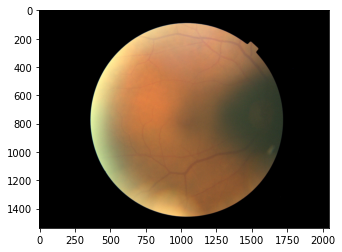

In [18]:
fileinfo("1250820_21016_0_0.png")

In [1]:
plt.hist(stats['PBV'], 100);
for i in thresholds:
    plt.vlines(i,0,15000)

NameError: name 'plt' is not defined

In [69]:
len(stats[stats['PBV']> thresholds[imax]])

117961